In [ ]:
!pip install fredpy --quiet

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import fredpy as fp
import datetime
from functools import reduce
import matplotlib.pyplot as plt

api_key = 'Fred API Key'
fp.api_key = api_key

In [ ]:
def download_to_excel(data=None, ticker='AAPL', leave_index=False):
  # Save to excel file
  if data is None:
    print("No data to save.")
    return

  file_name = f"{ticker}.xlsx"
  idx_nm = data.index.name
  try:
    data = data.reset_index()
    data[idx_nm] = data[idx_nm].dt.tz_localize(None)
  except:
    data = data.reset_index()
  data.to_excel(file_name, index=leave_index)  # by setting index=False, can erase pandas index

  # Can download from colab
  from google.colab import files
  files.download(file_name)

In [ ]:
def get_fred_data_multiple_series(api_key, series_ids, path='fred/series/observations', observation_date=None):
  """
  Retrieve multiple time series from the FRED API (St. Louis Fed),
  parse them into DataFrames, and inner-join them on the 'date' column.

  Parameters
  ----------
  fp : module or object
      An object that provides the method `fred_api_request`.
      For example, if you have a custom class or module named `fp`
      with the function signature:
          fp.fred_api_request(api_key, path, parameters) -> requests.Response
  api_key : str
      Your FRED API key.
  series_ids : list of str
      A list of FRED series IDs (e.g., ["UNRATE", "CPIAUCSL"]).
  path : str, optional
      The API endpoint path (default is 'fred/series/observations').
  observation_date : str, optional
      A date in 'YYYY-MM-DD' format. If not provided, uses today's date.

  Returns
  -------
  pd.DataFrame
      A single DataFrame containing columns for each requested series.
      Only rows where all series have matching dates are kept (inner join).
  """

  # If no observation_date is specified, default to today's date
  if observation_date is None:
      observation_date = datetime.datetime.today().strftime('%Y-%m-%d')

  # Dictionary to store each series' DataFrame by series_id
  df_dict = {}

  # Loop through each FRED series ID
  for s_id in series_ids:
    # Build the query parameters
    parameters = {
        'series_id': s_id,
        'observation_date': observation_date,
        'file_type': 'json'
    }

    # Make the API call
    r = fp.fred_api_request(api_key=api_key, path=path, parameters=parameters)

    # Parse the JSON response
    results = r.json()

    # Convert results to a DataFrame
    data = pd.DataFrame(results['observations'], columns=['date', 'value'])

    # Replace '.' with NaN
    data = data.replace('.', np.nan)

    # Convert 'date' to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Convert 'value' to float(Since most time, their data type is object)
    data['value'] = pd.to_numeric(data['value'], errors='coerce')

    # Set date as the index (helps with joining on date)
    data.set_index('date', inplace=True)

    # Rename the 'value' column to the series ID
    data.rename(columns={'value': s_id}, inplace=True)

    # Store in dictionary
    df_dict[s_id] = data

  # If only one series, just return it
  if len(df_dict) == 1:
      return df_dict[series_ids[0]]

  # Otherwise, inner-join all DataFrames on their index (the date)
  # This drops rows where any DataFrame is missing that date
  combined_df = reduce(lambda left, right: left.join(right, how='inner'),df_dict.values())

  return combined_df

In [ ]:
df = pd.read_excel("/content/econ.xlsx")
df

,date,CPIAUCSL,GDPDEF,DGS10,DGS2,Open,High,Low,Volume
0,1976-07,57.000,29.455,7.88,7.02,91.447620,91.447620,91.447620,0.000000e+00
1,1976-10,57.900,29.983,7.49,6.24,89.500000,89.500000,89.500000,0.000000e+00
2,1977-04,60.000,30.895,7.43,6.02,95.004501,95.004501,95.004501,0.000000e+00
3,1977-07,60.800,31.271,7.34,6.12,101.348948,101.348948,101.348948,0.000000e+00
4,1979-01,68.500,34.904,NaN,NaN,123.718182,123.718182,123.718182,0.000000e+00
...,...,...,...,...,...,...,...,...,...
130,2022-04,288.764,117.731,2.39,2.44,13479.614502,13596.793408,13276.163574,4.829050e+09
131,2022-07,294.977,119.057,2.88,2.84,11554.086084,11700.783936,11447.347949,4.714686e+09
132,2024-01,309.685,124.163,NaN,NaN,15065.246187,15153.820917,14988.519624,5.302441e+09
133,2024-04,313.207,124.943,4.33,4.72,15987.088157,16085.040838,15850.587225,4.887968e+09


In [ ]:
recent = df[100:][['CPIAUCSL','GDPDEF','DGS10','DGS2','Open','High','Low']]
recent

,CPIAUCSL,GDPDEF,DGS10,DGS2,Open,High,Low
100,231.638,93.885,1.64,0.25,3070.490002,3079.923816,3047.581903
101,231.679,94.258,NaN,NaN,3122.725202,3133.369036,3112.732887
102,231.797,94.461,1.86,0.23,3248.444103,3265.538619,3230.078180
103,232.900,94.924,2.50,0.34,3555.775468,3569.606845,3544.832730
104,233.669,95.426,2.66,0.33,3843.623057,3863.545654,3825.057798
105,235.288,95.788,NaN,NaN,4156.781878,4173.562872,4133.054292
106,236.468,96.330,2.77,0.44,4131.049049,4152.111456,4085.350923
107,237.498,96.726,2.58,0.47,4437.136830,4453.051869,4414.942294
108,237.430,96.822,2.42,0.53,4400.012207,4434.842519,4366.968708
109,234.747,96.769,NaN,NaN,4684.040991,4711.022021,4638.465479


In [ ]:
recent.corr()

,CPIAUCSL,GDPDEF,DGS10,DGS2,Open,High,Low
CPIAUCSL,1.000000,0.998163,0.431326,0.759824,0.929599,0.930101,0.929098
GDPDEF,0.998163,1.000000,0.396114,0.736255,0.942043,0.942592,0.941491
DGS10,0.431326,0.396114,1.000000,0.791270,0.206877,0.206405,0.206004
DGS2,0.759824,0.736255,0.791270,1.000000,0.543066,0.543320,0.541292
Open,0.929599,0.942043,0.206877,0.543066,1.000000,0.999991,0.999979
High,0.930101,0.942592,0.206405,0.543320,0.999991,1.000000,0.999954
Low,0.929098,0.941491,0.206004,0.541292,0.999979,0.999954,1.000000


In [ ]:
import requests

def get_fred_data(series_id, api_key):
  """FRED 시리즈 ID를 받아 해당 시리즈 관측값(Observations)을 JSON으로 반환."""
  url = "https://api.stlouisfed.org/fred/series/observations"
  params = {
      'series_id': series_id,
      'api_key': api_key,
      'file_type': 'json'  # json, xml, txt 가능
  }

  response = requests.get(url, params=params)

  # 요청 성공 여부 체크
  response.raise_for_status()

  data = response.json()
  return data

In [ ]:
from bs4 import BeautifulSoup as bs
def fomc_meeting_schedule(year):
  url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm"
  response = requests.get(url)

  if response.status_code == 200:
    soup = bs(response.text, 'html.parser')
    h5_tags = soup.find_all('h5')
    schedule = []
    for h5 in h5_tags:
      schedule.append(h5.text)
    return schedule
  else:
      print(f"요청 실패: {response.status_code}")

In [ ]:
import copy
def convert_to_date(data):
  data_copy = copy.deepcopy(data)
  for i in range(len(data_copy)):
    date = data_copy[i].split()
    if(len(date) < 3):
      return f'index number {i}: format is wrong {date}'
    date_str = data_copy[i].split()[0] + ' ' + f'{data_copy[i].split()[1][-1] if len(data_copy[i].split()[1])>2 else data_copy[i].split()[1]}' + ' '+ data_copy[i].split()[-1] # 날짜가 1-2이런 식으로 된 데이터 처리
    data_copy[i] = datetime.datetime.strptime(date_str, '%B %d %Y').strftime('%Y-%m-%d')
  return data_copy

In [ ]:
data = fomc_meeting_schedule(2010)
data

['January 26-27 Meeting - 2010',
 'March 16 Meeting - 2010',
 'April 27-28 Meeting - 2010',
 'May 9 Conference Call - 2010',
 'June 22-23 Meeting - 2010',
 'August 10 Meeting - 2010',
 'September 21 Meeting - 2010',
 'October 15 Conference Call - 2010',
 'November 2-3 Meeting - 2010',
 'December 14 Meeting - 2010']

In [ ]:
new_data = convert_to_date(data)

In [ ]:
new_data

['2010-01-07',
 '2010-03-16',
 '2010-04-08',
 '2010-05-09',
 '2010-06-03',
 '2010-08-10',
 '2010-09-21',
 '2010-10-15',
 '2010-11-03',
 '2010-12-14']

In [ ]:
print(data[0].split()[1])
print(len(data[0].split()[1]))
print(len(data[1].split()[1]))

1-2
3
2


In [ ]:
API_KEY = api_key

y10_bond_data = get_fred_data("DGS10", API_KEY)
y2_data = get_fred_data("DGS2", API_KEY)
nasdaq_data = get_fred_data("NASDAQCOM", API_KEY)
m2_data = get_fred_data("WM2NS", API_KEY)
gdp_data = get_fred_data("GDP", API_KEY)
cpi_data = get_fred_data("CORESTICKM159SFRBATL", API_KEY)
unemployment_data = get_fred_data("UNRATE", API_KEY)

# observations 항목에 날짜별 데이터가 들어있음
# observations = data["observations"]

In [ ]:
y10_bond_df = pd.DataFrame(y10_bond_data['observations'])
y2_df = pd.DataFrame(y2_data['observations'])
nasdaq_df = pd.DataFrame(nasdaq_data['observations'])
m2_df = pd.DataFrame(m2_data['observations'])
cpi_df = pd.DataFrame(cpi_data['observations'])
gdp_df = pd.DataFrame(gdp_data['observations'])
unemployment_df = pd.DataFrame(unemployment_data['observations'])

y10_bond_df['date'] = pd.to_datetime(y10_bond_df['date'])
y10_bond_df['value'] = pd.to_numeric(y10_bond_df['value'], errors='coerce')
y2_df['date'] = pd.to_datetime(y2_df['date'])
y2_df['value'] = pd.to_numeric(y2_df['value'], errors='coerce')
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
nasdaq_df['value'] = pd.to_numeric(nasdaq_df['value'], errors='coerce')
m2_df['date'] = pd.to_datetime(m2_df['date'])
m2_df['value'] = pd.to_numeric(m2_df['value'], errors='coerce')
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df['value'] = pd.to_numeric(cpi_df['value'], errors='coerce')
gdp_df['date'] = pd.to_datetime(gdp_df['date'])
gdp_df['value'] = pd.to_numeric(gdp_df['value'], errors='coerce')
unemployment_df['date'] = pd.to_datetime(unemployment_df['date'])
unemployment_df['value'] = pd.to_numeric(unemployment_df['value'], errors='coerce')

In [ ]:
# gdp는 분기데이터 / 직전 년도 동기로 비교해야됨
gdp_df['pct_change'] = (gdp_df['value'] - gdp_df['value'].shift(3)) / gdp_df['value'].shift(3) * 100
gdp_df

,realtime_start,realtime_end,date,value,pct_change
0,2024-12-19,2024-12-19,1946-01-01,NaN,NaN
1,2024-12-19,2024-12-19,1946-04-01,NaN,NaN
2,2024-12-19,2024-12-19,1946-07-01,NaN,NaN
3,2024-12-19,2024-12-19,1946-10-01,NaN,NaN
4,2024-12-19,2024-12-19,1947-01-01,243.164,NaN
...,...,...,...,...,...
310,2024-12-19,2024-12-19,2023-07-01,27967.697,4.613628
311,2024-12-19,2024-12-19,2023-10-01,28296.967,4.169463
312,2024-12-19,2024-12-19,2024-01-01,28624.069,4.262628
313,2024-12-19,2024-12-19,2024-04-01,29016.714,3.750817


In [ ]:
def count_return(data, start_date='2021-01-01', end_date='2024-12-31'):
  """
  Count how many positive changes in the data during given period
  """
  pos_count = 0
  neg_count = 0
  filtered_df = data[(data['date']>=start_date) & (data['date']<=end_date)]
  filtered_df = filtered_df.dropna()
  filtered_df['pct_change'] = filtered_df['value'].pct_change()
  for i in filtered_df['pct_change']:
    if i >= 0:
      pos_count += 1
    elif i < 0:
      neg_count += 1
  return (pos_count, neg_count)

In [ ]:
# filtered_df_21to24 = nasdaq_df[(nasdaq_df['date'] >= '2021-01-01') & (nasdaq_df['date'] <= '2024-12-31')][['date','value']]
pos, neg = count_return(nasdaq_df)
print(pos/(pos+neg))

0.5388446215139442


In [ ]:
def simple_plot_data(data, data_names, start_date, end_date, figsize=(20,12), sub_row=2, sub_col=2):
  plt.figure(figsize=figsize)
  for i, df in enumerate(data):
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)][['date','value']]
    plt.subplot(sub_row,sub_col,i+1)
    plt.plot(filtered_df['date'],filtered_df['value'])
    if i >= len(data)-2:
      plt.xticks(rotation=90)
    else:
      plt.xticks([])
    plt.title(data_names[i])
  plt.tight_layout()
  plt.show()

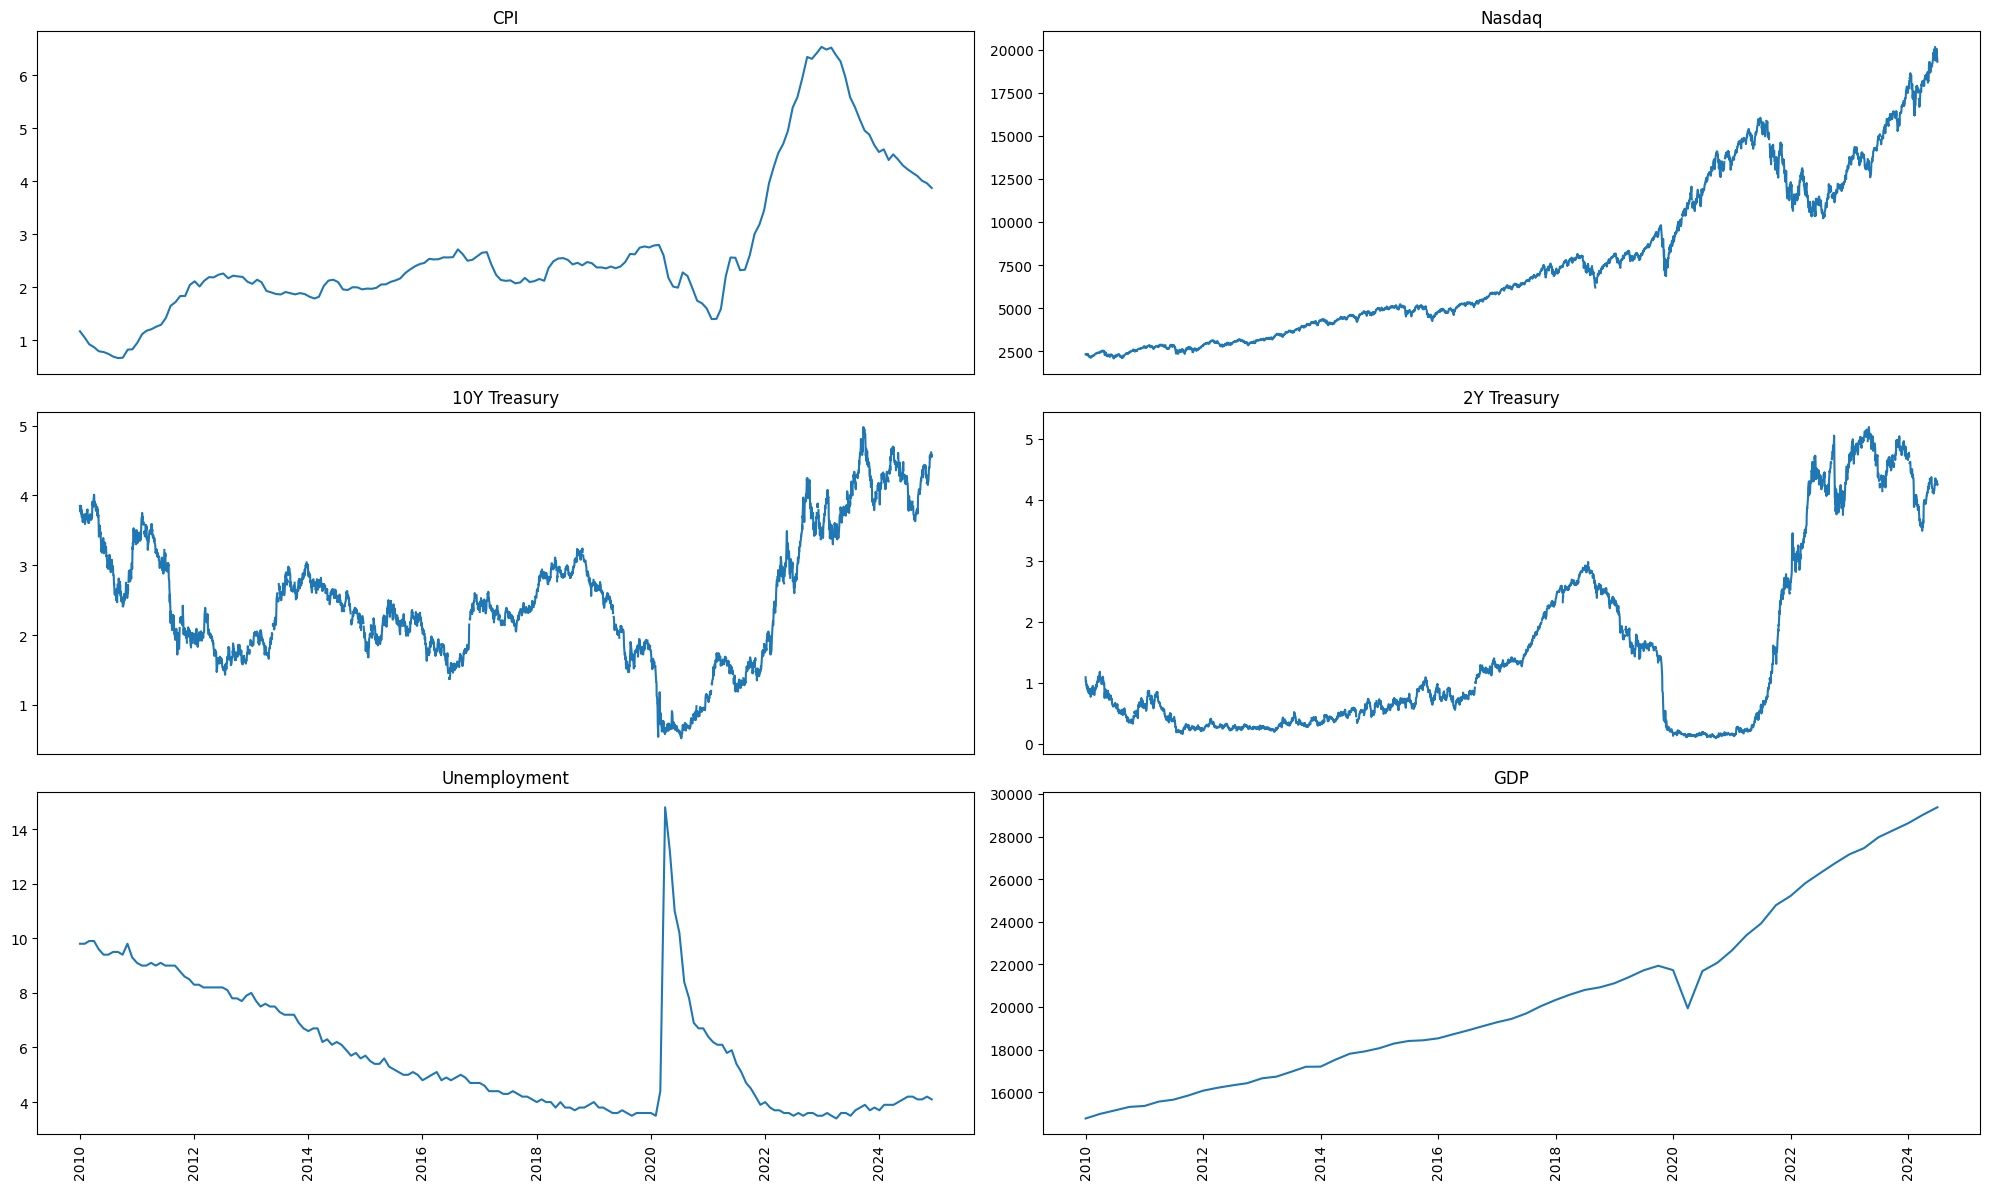

In [ ]:
start_date = '2010-01-01'
end_date = '2024-12-31'
figsize = (10,6)
sub_row = 2
datas = [cpi_df, nasdaq_df, y10_bond_df, y2_df,unemployment_df]
data_names = ['CPI','Nasdaq','10Y Treasury','2Y Treasury','Unemployment'] # Unit of GDP is $billion.
simple_plot_data(data=datas, data_names=data_names, start_date=start_date, end_date=end_date, sub_row=sub_row)

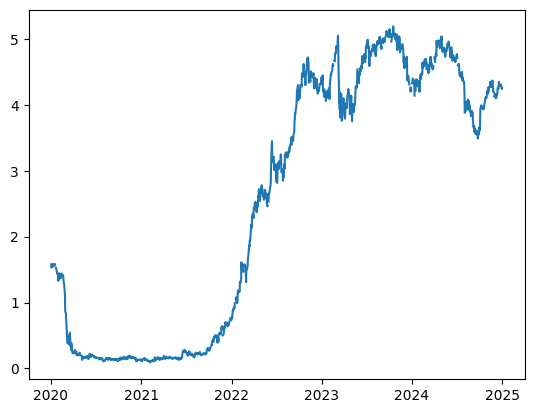

In [ ]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
plt.plot(filtered_df['date'],filtered_df['value'])

In [ ]:
y2_df[y2_df['date']>='2000-01-01']

,realtime_start,realtime_end,date,value
6154,2025-01-10,2025-01-10,2000-01-03,6.38
6155,2025-01-10,2025-01-10,2000-01-04,6.30
6156,2025-01-10,2025-01-10,2000-01-05,6.38
6157,2025-01-10,2025-01-10,2000-01-06,6.35
6158,2025-01-10,2025-01-10,2000-01-07,6.31
...,...,...,...,...
12678,2025-01-10,2025-01-10,2025-01-03,4.28
12679,2025-01-10,2025-01-10,2025-01-06,4.28
12680,2025-01-10,2025-01-10,2025-01-07,4.30
12681,2025-01-10,2025-01-10,2025-01-08,4.28


In [ ]:
y10_bond_df[y10_bond_df['date']>='2000-01-01']

,realtime_start,realtime_end,date,value
9914,2025-01-10,2025-01-10,2000-01-03,6.58
9915,2025-01-10,2025-01-10,2000-01-04,6.49
9916,2025-01-10,2025-01-10,2000-01-05,6.62
9917,2025-01-10,2025-01-10,2000-01-06,6.57
9918,2025-01-10,2025-01-10,2000-01-07,6.52
...,...,...,...,...
16438,2025-01-10,2025-01-10,2025-01-03,4.60
16439,2025-01-10,2025-01-10,2025-01-06,4.62
16440,2025-01-10,2025-01-10,2025-01-07,4.67
16441,2025-01-10,2025-01-10,2025-01-08,4.67


In [ ]:
y2_df_re = y2_df[y2_df['date']>='2000-01-01'].reset_index()
y2_df_re = y2_df_re[['date','value']]
y10_df_re = y10_bond_df[y10_bond_df['date']>='2000-01-01'].reset_index()[['date','value']]
y10_df_re = y10_df_re[['date','value']]

In [ ]:
y2_df_re_2020 = y2_df_re[y2_df_re['date'] >= '2020-01-01']
y2_df_re_2020

,date,value
5217,2020-01-01,NaN
5218,2020-01-02,1.58
5219,2020-01-03,1.53
5220,2020-01-06,1.54
5221,2020-01-07,1.54
...,...,...
6524,2025-01-03,4.28
6525,2025-01-06,4.28
6526,2025-01-07,4.30
6527,2025-01-08,4.28


In [ ]:
y10_df_re_2020 = y10_df_re[y10_df_re['date'] >= '2020-01-01']
y10_df_re_2020

,date,value
5217,2020-01-01,NaN
5218,2020-01-02,1.88
5219,2020-01-03,1.80
5220,2020-01-06,1.81
5221,2020-01-07,1.83
...,...,...
6524,2025-01-03,4.60
6525,2025-01-06,4.62
6526,2025-01-07,4.67
6527,2025-01-08,4.67


In [ ]:
highlight_condi

,date,value
5804,2022-04-01,2.44
5805,2022-04-04,2.43
5872,2022-07-06,2.97
5873,2022-07-07,3.03
5874,2022-07-08,3.12
...,...,...
6428,2024-08-22,3.99
6429,2024-08-23,3.90
6430,2024-08-26,3.91
6436,2024-09-03,3.88


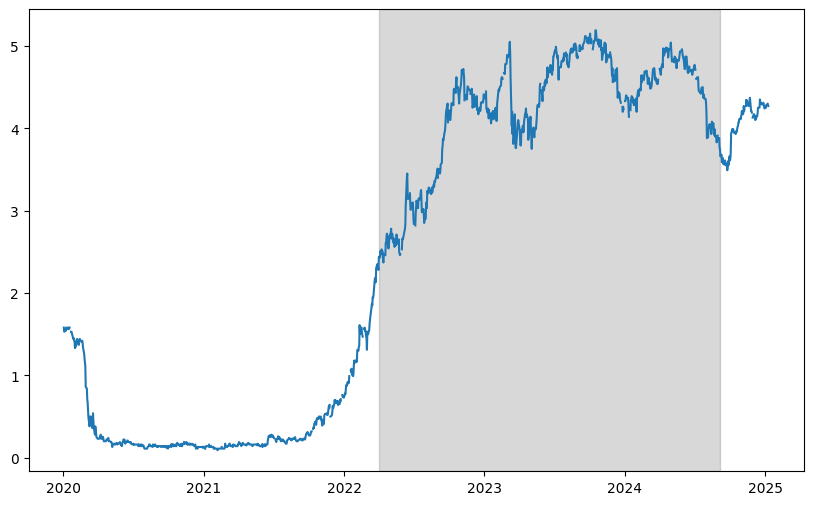

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y2_df_re_2020['date'], y2_df_re_2020['value'], label='Value')
if not highlight_dates.empty:
  ax.axvspan(
      highlight_dates.min(),  # 조건을 만족하는 최소 날짜
      highlight_dates.max(),  # 조건을 만족하는 최대 날짜
      color='gray', alpha=0.3, label='Highlighted Period'
  )

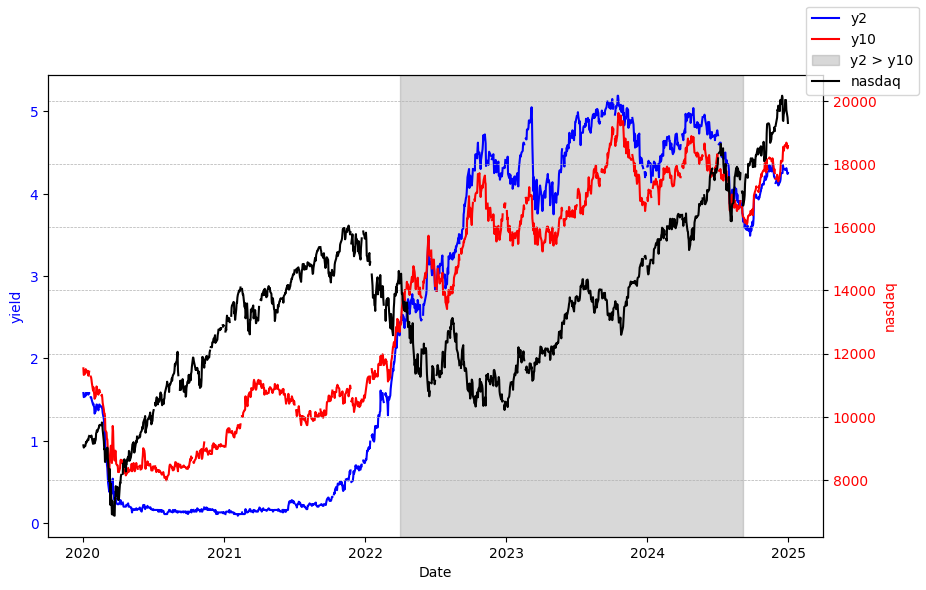

In [ ]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_y2_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
filtered_y10_df = y10_bond_df[(y10_bond_df['date'] >= start_date) & (y10_bond_df['date'] <= end_date)][['date','value']]
filtered_nasdaq_df = nasdaq_df[(nasdaq_df['date'] >= start_date) & (nasdaq_df['date'] <= end_date)][['date','value']]
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(filtered_y2_df['date'],filtered_y2_df['value'],label='y2',color='blue')
ax1.plot(filtered_y10_df['date'],filtered_y10_df['value'],label='y10',color='red')
ax1.set_ylabel('yield', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(filtered_nasdaq_df['date'],filtered_nasdaq_df['value'],label='nasdaq',color='black')
ax2.set_ylabel('nasdaq', color='red')
ax2.tick_params(axis='y', labelcolor='red')

highlight_condi = y2_df_re_2020['value']>y10_df_re_2020['value']
highlight_dates = y2_df_re_2020.loc[highlight_condi, 'date']
if not highlight_dates.empty:
  ax1.axvspan(
      highlight_dates.min(),
      highlight_dates.max(),
      color='gray', alpha=0.3, label='y2 > y10'
  )

ax1.set_xlabel('Date')
fig.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

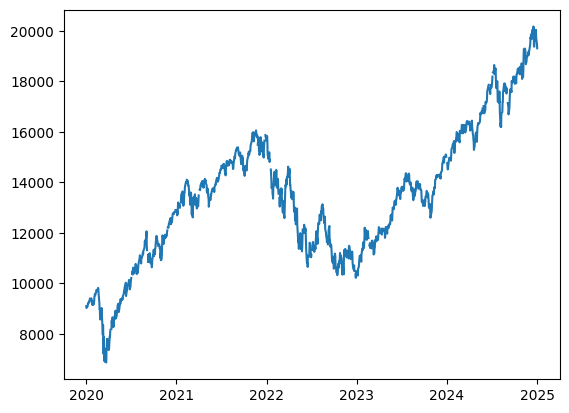

In [ ]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = nasdaq_df[(nasdaq_df['date'] >= start_date) & (nasdaq_df['date'] <= end_date)][['date','value']]
plt.plot(filtered_df['date'],filtered_df['value'])

In [ ]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1251.000000
mean,2.515244
std,1.966624
min,0.090000
25%,0.220000
50%,3.030000
75%,4.400000
max,5.190000


In [ ]:
filtered_df = y10_bond_df[(y10_bond_df['date'] >= start_date) & (y10_bond_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1251.000000
mean,2.688074
std,1.392846
min,0.520000
25%,1.425000
50%,2.940000
75%,4.005000
max,4.980000


In [ ]:
start_date = '2010-01-01'
end_date = '2015-12-31'

In [ ]:
filtered_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1502.000000
mean,0.481085
std,0.219409
min,0.160000
25%,0.290000
50%,0.430000
75%,0.630000
max,1.180000


In [ ]:
filtered_df = y10_bond_df[(y10_bond_df['date'] >= start_date) & (y10_bond_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1502.000000
mean,2.471631
std,0.594112
min,1.430000
25%,2.000000
50%,2.360000
75%,2.820000
max,4.010000


In [ ]:
start_date = '2000-01-01'
end_date = '2005-12-31'
filtered_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1499.000000
mean,3.437392
std,1.567291
min,1.100000
25%,2.040000
50%,3.170000
75%,4.270000
max,6.930000


In [ ]:
filtered_df = y10_bond_df[(y10_bond_df['date'] >= start_date) & (y10_bond_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1499.000000
mean,4.706818
std,0.759719
min,3.130000
25%,4.160000
50%,4.480000
75%,5.170000
max,6.790000


In [ ]:
start_date = '2005-01-01'
end_date = '2010-12-31'
filtered_df = y2_df[(y2_df['date'] >= start_date) & (y2_df['date'] <= end_date)][['date','value']]
print(filtered_df[filtered_df['value'] == max(filtered_df['value'])])
filtered_df['value'].describe()

           date  value
7846 2006-06-28   5.29


,value
count,1503.000000
mean,2.784318
std,1.683548
min,0.330000
25%,0.960000
50%,2.940000
75%,4.530000
max,5.290000


In [ ]:
filtered_df = y10_bond_df[(y10_bond_df['date'] >= start_date) & (y10_bond_df['date'] <= end_date)][['date','value']]
filtered_df['value'].describe()

,value
count,1503.000000
mean,3.976720
std,0.723033
min,2.080000
25%,3.495000
50%,4.030000
75%,4.580000
max,5.260000


In [ ]:
y2_df[y2_df['value'] == max(y2_df['value'])]

,realtime_start,realtime_end,date,value
1375,2025-01-10,2025-01-10,1981-09-08,16.95
1376,2025-01-10,2025-01-10,1981-09-09,16.95


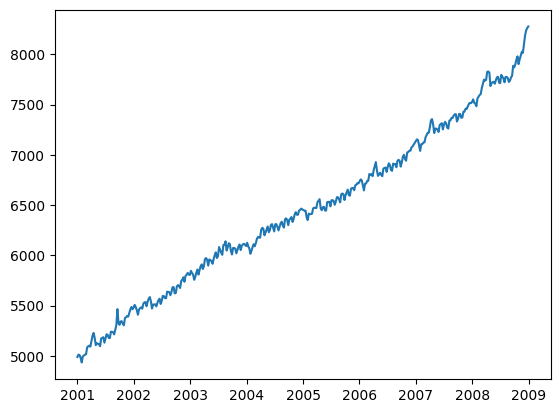

In [ ]:
filtered_df = m2_df[(m2_df['date'] >= start_date) & (m2_df['date'] <= end_date)][['date','value']]
plt.plot(filtered_df['date'],filtered_df['value'])

In [ ]:
download_to_excel(y10_bond_df, 'y10_bond')
download_to_excel(y2_df, 'y2')
download_to_excel(nasdaq_df, 'nasdaq')
download_to_excel(m2_df, 'm2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(y10_bond_df[['date']].info())
print(y2_df[['date']].info())
print(nasdaq_df[['date']].info())
print(m2_df[['date']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16439 entries, 0 to 16438
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16439 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 128.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12679 entries, 0 to 12678
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12679 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 99.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14067 entries, 0 to 14066
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    14067 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 110.0 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2301 entries, 0 to 2300
Data columns (total 1 columns):
 #   Column  

In [ ]:
se = ['GDP','NASDAQCOM','DGS10','DGS2','WM2NS']
df = get_fred_data_multiple_series(api_key=api_key, series_ids=se)
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date') # Set 'Date' column as index
df.index = df.index.to_period('M')
df

,GDP,NASDAQCOM,DGS10,DGS2,WM2NS
date,,,,,
1984-10,4148.551,247.86,12.54,12.09,2243.1
1985-04,4294.887,280.32,11.66,10.45,2368.1
1985-07,4386.773,296.48,10.19,8.66,2421.1
1990-01,5872.701,NaN,NaN,NaN,3181.9
1990-10,6004.733,354.65,8.71,7.94,3242.6
1991-04,6126.862,480.86,8.07,7.01,3339.8
1991-07,6205.937,481.31,8.26,6.97,3346.1
1996-01,7868.468,NaN,NaN,NaN,3661.5
1996-04,8032.840,1106.57,6.31,5.79,3702.9


In [ ]:
df = df.reset_index()
df = df[['GDP','NASDAQCOM','DGS10','DGS2','WM2NS']]
df